In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pingouin as pg
import numpy as np
from scipy.stats import ks_2samp
from scipy.stats import linregress
from scipy.stats import fisher_exact
from scipy.stats import chi2_contingency


/opt/miniconda3/envs/databs/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.6, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/opt/miniconda3/envs/databs/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
def ecdf(raw_data):
    '''[np.array -> tuple]
    Equivalent to R's ecdf(). Credit to Kripanshu Bhargava from Codementor'''
    cdfx = np.unique(raw_data)
    x_values = np.linspace(start=min(cdfx), stop=max(cdfx), num=len(cdfx))
    size_data = raw_data.size
    y_values = []
    for i in x_values:
        # all the values in raw data less than the ith value in x_values
        temp = raw_data[raw_data <= i]
        # fraction of that value with respect to the size of the x_values
        value = temp.size / size_data

        y_values.append(value)
    
    y_values = np.array(y_values)
    
    return (x_values, y_values)

# Spine Density

In [3]:
spines = pd.read_csv('/Users/labc02/Documents/PDCB_data/Morphometry/Spine_Count.csv')

### Thorny Excrescences 

In [4]:
sp_TE = spines[spines['Order'] < 3]
sp_normal = spines[spines['Order'] == 3]

In [5]:
spines.columns

Index(['ID', 'Genotype', 'Sample', 'Order', 'Lenght', 'Spines'], dtype='object')

In [6]:
sp_TE.groupby(['Genotype'])['ID'].count()

Genotype
KO    12
WT    15
Name: ID, dtype: int64

#### Thorny excrescence expressed as number of spine heads in 20 micrometers of dendrite

In [7]:
sp_TE['Density'] = sp_TE['Spines']/sp_TE['Lenght'] * 20

<ipython-input-7-088b22520e60>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_TE['Density'] = sp_TE['Spines']/sp_TE['Lenght'] * 20


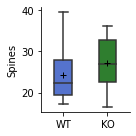

In [15]:
th_density_fig = plt.figure(figsize=(2, 2))
sns.boxplot(data = sp_TE, x = 'Genotype', y = 'Density', palette=['royalblue', 'forestgreen'], order = ['WT', 'KO'], showmeans=True, showfliers = True, meanprops={'marker':'+', 'markeredgecolor':'k'}, width=0.4)
sns.despine()
plt.ylabel('Spines')
plt.xlabel('')
plt.tight_layout()


In [16]:
th_density_fig.savefig('/Users/labc02/Documents/PDCB_data/Morphometry/Figures/TH_desnity.svg')

In [17]:
pg.normality(data = sp_TE, dv = 'Density', group = 'Genotype')

,W,pval,normal
KO,0.936478,0.453832,True
WT,0.875469,0.040628,False


In [18]:
pg.mwu(x = sp_TE['Density'][sp_TE['Genotype']=='WT'], y = sp_TE['Density'][sp_TE['Genotype']=='KO'], tail ='one-sided')

,U-val,tail,p-val,RBC,CLES
MWU,68.0,less,0.147068,0.244444,0.622222


#### A tendency in accordance to the propotion of axons with MFB and Timm area, but no statistically significant

### Normal spines

In [19]:
sp_normal.groupby(['Genotype'])['ID'].count()

Genotype
KO    21
WT    20
Name: ID, dtype: int64

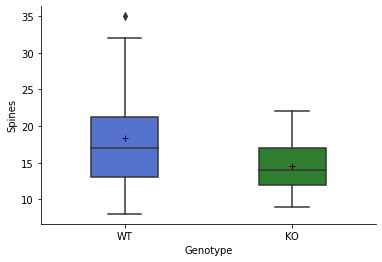

In [20]:
sns.boxplot(data = sp_normal, x = 'Genotype', y = 'Spines', palette=['royalblue', 'forestgreen'], order = ['WT', 'KO'], showmeans=True, showfliers = True, meanprops={'marker':'+', 'markeredgecolor':'k'}, width=0.4)
sns.despine()

#### Outlier detection

In [21]:
out_WT = pg.madmedianrule(sp_normal['Spines'][sp_normal['Genotype'] == 'WT'])

In [22]:
sp_normal['Spines'][sp_normal['Genotype'] == 'WT'][out_WT]

39    35
41    32
Name: Spines, dtype: int64

In [23]:
sp_tidy = sp_normal.drop(index = [39, 41])

In [24]:
sp_tidy.groupby('Genotype')['ID'].count()

Genotype
KO    21
WT    18
Name: ID, dtype: int64

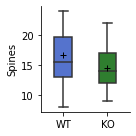

In [25]:
Nl_spines_fig = plt.figure(figsize=(2,2))
sns.boxplot(data = sp_tidy, x = 'Genotype', y = 'Spines', palette=['royalblue', 'forestgreen'], order = ['WT', 'KO'], showmeans=True, showfliers = False, meanprops={'marker':'+', 'markeredgecolor':'k'}, width=0.4)
sns.despine()
plt.ylabel('Spines')
plt.xlabel('')
plt.tight_layout()


In [28]:
Nl_spines_fig.savefig('/Users/labc02/Documents/PDCB_data/Morphometry/Figures/Nl_density.svg')

In [26]:
pg.normality(data = sp_tidy, dv = 'Spines', group = 'Genotype')

,W,pval,normal
KO,0.967427,0.675686,True
WT,0.960308,0.607598,True


In [27]:
pg.ttest(sp_tidy['Spines'][sp_tidy['Genotype']=='WT'], sp_tidy['Spines'][sp_tidy['Genotype']=='KO'])

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,1.482769,28.679949,two-sided,0.149042,"[-0.84, 5.23]",0.491298,0.738,0.319438


#### A tendency in the other direction, not significant

## Mossy Fiber Buttons

In [29]:
mfb_df = pd.read_csv('/Users/labc02/Documents/PDCB_data/Morphometry/MFB_database.csv')

In [30]:
mfb_df.columns

Index(['ID', 'Genotype', 'Filopoia', 'Volume', 'Cr_Diameter'], dtype='object')

In [31]:
mfb_df.groupby('Genotype')['ID'].count()

Genotype
KO    35
WT    49
Name: ID, dtype: int64

#### Filopodia

In [32]:
ko_fil = mfb_df['Filopoia'][mfb_df['Genotype'] == 'KO']
wt_fil = mfb_df['Filopoia'][mfb_df['Genotype'] == 'WT']


In [33]:
# ECDF for filopodia
wt_fil_ecdf = ecdf(wt_fil)
ko_fil_ecdf = ecdf(ko_fil)

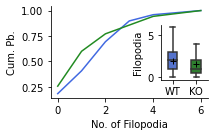

In [290]:
fil_fig = plt.figure(figsize = (3, 2))

fil_ax = plt.subplot()
fil_ax.plot(wt_fil_ecdf[0], wt_fil_ecdf[1], color = 'royalblue')
fil_ax.plot(ko_fil_ecdf[0], ko_fil_ecdf[1], color = 'forestgreen')
fil_ax.spines['right'].set_visible(False)
fil_ax.spines['top'].set_visible(False)
fil_ax.set_xlabel('No. of Filopodia')
fil_ax.set_ylabel('Cum. Pb.')

box_ax = fil_ax.inset_axes([0.7, 0.2, 0.3, 0.6])
sns.boxplot(data = mfb_df, x = 'Genotype', y = 'Filopoia', palette=['royalblue', 'forestgreen'], order = ['WT', 'KO'], showmeans=True, showfliers = False, meanprops={'marker':'+', 'markeredgecolor':'k'}, width=0.4, ax = box_ax)
box_ax.set_ylabel('Filopodia')
box_ax.set_xlabel('')
box_ax.spines['right'].set_visible(False)
box_ax.spines['top'].set_visible(False)

plt.tight_layout()


In [291]:
fil_fig.savefig('/Users/labc02/Documents/PDCB_data/Morphometry/Figures/filopodia.svg')

In [44]:
# Mann-Whitney U
pg.mwu(mfb_df['Filopoia'][mfb_df['Genotype']=='WT'], mfb_df['Filopoia'][mfb_df['Genotype']=='KO'], tail = 'greater')

,U-val,tail,p-val,RBC,CLES
MWU,989.0,greater,0.111604,-0.153353,0.478134


In [45]:
# Kolmogorov-Smirnov for ECDF
ks_2samp(wt_fil_ecdf[1], ko_fil_ecdf[1])

Ks_2sampResult(statistic=0.14285714285714285, pvalue=0.9999997041284721)

### Volume

In [47]:
ko_vol = mfb_df['Volume'][mfb_df['Genotype'] == 'KO'].round()
wt_vol = mfb_df['Volume'][mfb_df['Genotype'] == 'WT'].round()

# ECDF for filopodia
wt_vol_ecdf = ecdf(wt_vol)
ko_vol_ecdf = ecdf(ko_vol)

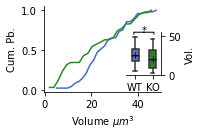

In [75]:
vol_fig = plt.figure(figsize = (3, 2))

vol_ax = plt.subplot()
vol_ax.plot(wt_vol_ecdf[0], wt_vol_ecdf[1], color = 'royalblue')
vol_ax.plot(ko_vol_ecdf[0], ko_vol_ecdf[1], color = 'forestgreen')
vol_ax.spines['right'].set_visible(False)
vol_ax.spines['top'].set_visible(False)
vol_ax.set_xlabel(r'Volume $\mu m^3$')
vol_ax.set_ylabel('Cum. Pb.')

box_ax = vol_ax.inset_axes([0.7, 0.2, 0.3, 0.5])
sns.boxplot(data = mfb_df, x = 'Genotype', y = 'Volume', palette=['royalblue', 'forestgreen'], order = ['WT', 'KO'], showmeans=True, showfliers = False, meanprops={'marker':'+', 'markeredgecolor':'k'}, width=0.4, ax = box_ax)
box_ax.yaxis.tick_right()
box_ax.yaxis.set_label_position("right")
box_ax.set_ylabel(r'Vol.')
box_ax.set_xlabel('')
box_ax.spines['left'].set_visible(False)
box_ax.spines['top'].set_visible(False)
box_ax.set_ylim(0, 55)
box_ax.annotate('*', xy = (0.5, 0.95), xytext = (0.5, 0.98), xycoords = 'axes fraction', ha = 'center', arrowprops=dict(arrowstyle='-[, widthB=1, lengthB=.2', lw=1, color='k'), fontsize = 10)

plt.tight_layout()

In [76]:
vol_fig.savefig('/Users/labc02/Documents/PDCB_data/Morphometry/Figures/MFBvol.svg')

In [71]:
# Kolmogorov-Smirnov for ECDF
ks_2samp(wt_vol_ecdf[1], ko_vol_ecdf[1])

Ks_2sampResult(statistic=0.20142857142857143, pvalue=0.5762251456982352)

In [72]:
pg.normality(data = mfb_df, dv = 'Volume', group = 'Genotype')

,W,pval,normal
KO,0.929359,0.026775,False
WT,0.978252,0.494352,True


In [73]:
# Mann-Whitney U
pg.mwu(mfb_df['Volume'][mfb_df['Genotype']=='WT'], mfb_df['Volume'][mfb_df['Genotype']=='KO'], tail = 'greater')

,U-val,tail,p-val,RBC,CLES
MWU,1056.5,greater,0.035852,-0.23207,0.615743


#### Smaller volume in average for KO

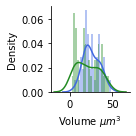

In [321]:
volume_dist = plt.figure(figsize=(2,2))

sns.distplot(mfb_df['Volume'][mfb_df['Genotype']== 'WT'], hist = True, color = 'royalblue', bins = 20, kde = True)
sns.distplot(mfb_df['Volume'][mfb_df['Genotype']== 'KO'], hist= True, color = 'forestgreen', bins = 20, kde = True)
sns.despine()
plt.ylabel('Density')
plt.xlabel(r'Volume $\mu m^3$')
plt.tight_layout()

In [322]:
volume_dist.savefig('/Users/labc02/Documents/PDCB_data/Morphometry/Figures/MFBdist.svg')

## Cross-sectional Diameter

In [111]:
ko_dmt = mfb_df['Cr_Diameter'][mfb_df['Genotype'] == 'KO'].round()
wt_dmt = mfb_df['Cr_Diameter'][mfb_df['Genotype'] == 'WT'].round()

# ECDF for filopodia
wt_dmt_ecdf = ecdf(wt_dmt)
ko_dmt_ecdf = ecdf(ko_dmt)

Text(0.5, 0.97, '***')

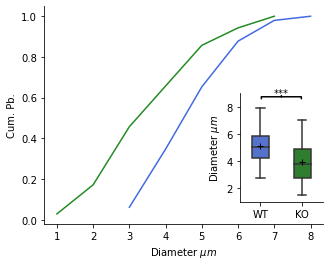

In [112]:
dmt_fig = plt.figure(figsize = (5, 4))

dmt_ax = plt.subplot()
dmt_ax.plot(wt_dmt_ecdf[0], wt_dmt_ecdf[1], color = 'royalblue')
dmt_ax.plot(ko_dmt_ecdf[0], ko_dmt_ecdf[1], color = 'forestgreen')
dmt_ax.spines['right'].set_visible(False)
dmt_ax.spines['top'].set_visible(False)
dmt_ax.set_xlabel(r'Diameter $\mu m$')
dmt_ax.set_ylabel('Cum. Pb.')

box_ax = dmt_ax.inset_axes([0.7, 0.1, 0.3, 0.5])
sns.boxplot(data = mfb_df, x = 'Genotype', y = 'Cr_Diameter', palette=['royalblue', 'forestgreen'], order = ['WT', 'KO'], showmeans=True, showfliers = False, meanprops={'marker':'+', 'markeredgecolor':'k'}, width=0.4, ax = box_ax)
box_ax.set_ylabel(r'Diameter $\mu m$')
box_ax.set_xlabel('')
box_ax.spines['right'].set_visible(False)
box_ax.spines['top'].set_visible(False)
box_ax.set_ylim(1, 9)
box_ax.annotate('***', xy = (0.5, 0.95), xytext = (0.5, 0.97), xycoords = 'axes fraction', ha = 'center', arrowprops=dict(arrowstyle='-[, widthB=2, lengthB=.2', lw=1.5, color='k'), fontsize = 10)



In [113]:
# Kolmogorov-Smirnov for ECDF
ks_2samp(wt_dmt_ecdf[1], ko_dmt_ecdf[1])

Ks_2sampResult(statistic=0.21428571428571427, pvalue=0.9906759906759907)

In [114]:
pg.normality(data = mfb_df, dv = 'Cr_Diameter', group = 'Genotype')

,W,pval,normal
KO,0.976908,0.656722,True
WT,0.983042,0.696972,True


In [115]:
pg.ttest(mfb_df['Cr_Diameter'][mfb_df['Genotype']=='WT'], mfb_df['Cr_Diameter'][mfb_df['Genotype']=='KO'], tail = 'greater')

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,3.952724,62.307545,greater,0.0001,"[0.68, inf]",0.909635,288.949,0.992473


In [116]:
# Linear regression for Diameter/vol

wt_res = linregress(mfb_df['Cr_Diameter'][mfb_df['Genotype']== 'WT'], mfb_df['Volume'][mfb_df['Genotype']== 'WT'])

In [117]:
wt_res

LinregressResult(slope=3.9967847080098062, intercept=5.055386111353226, rvalue=0.4875253569909244, pvalue=0.0003809404212348421, stderr=1.0440781249256288)

In [118]:
# Linear regression for Diameter/vol

ko_res = linregress(mfb_df['Cr_Diameter'][mfb_df['Genotype']== 'KO'], mfb_df['Volume'][mfb_df['Genotype']== 'KO'])

In [119]:
ko_res

LinregressResult(slope=6.921188821218585, intercept=-6.363234784694683, rvalue=0.7678760246745948, pvalue=7.297456346714532e-08, stderr=1.0051214071483086)

Text(0, 0.5, 'Volume $\\mu m^3$')

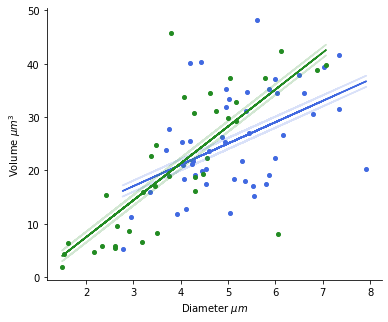

In [120]:
linres_fig = plt.figure(figsize=(6,5))
linres_ax = plt.subplot()

linres_ax.scatter(x = mfb_df['Cr_Diameter'][mfb_df['Genotype']== 'WT'], y = mfb_df['Volume'][mfb_df['Genotype']== 'WT'], s = 16, c = 'royalblue', marker = 'o')
linres_ax.scatter(x = mfb_df['Cr_Diameter'][mfb_df['Genotype']== 'KO'], y = mfb_df['Volume'][mfb_df['Genotype']== 'KO'], s = 16, c = 'forestgreen', marker = 'o')

linres_ax.plot(mfb_df['Cr_Diameter'][mfb_df['Genotype']== 'WT'], wt_res.intercept + wt_res.slope*mfb_df['Cr_Diameter'][mfb_df['Genotype']== 'WT'], color = 'royalblue')
linres_ax.plot(mfb_df['Cr_Diameter'][mfb_df['Genotype']== 'WT'], wt_res.intercept + wt_res.slope*mfb_df['Cr_Diameter'][mfb_df['Genotype']== 'WT']+wt_res.stderr, color = 'royalblue', alpha = 0.2)
linres_ax.plot(mfb_df['Cr_Diameter'][mfb_df['Genotype']== 'WT'], wt_res.intercept + wt_res.slope*mfb_df['Cr_Diameter'][mfb_df['Genotype']== 'WT']-wt_res.stderr, color = 'royalblue', alpha = 0.2)

linres_ax.plot(mfb_df['Cr_Diameter'][mfb_df['Genotype']== 'KO'], ko_res.intercept + ko_res.slope*mfb_df['Cr_Diameter'][mfb_df['Genotype']== 'KO'], color = 'forestgreen')
linres_ax.plot(mfb_df['Cr_Diameter'][mfb_df['Genotype']== 'KO'], ko_res.intercept + ko_res.slope*mfb_df['Cr_Diameter'][mfb_df['Genotype']== 'KO']+ko_res.stderr, color = 'forestgreen', alpha = 0.2)
linres_ax.plot(mfb_df['Cr_Diameter'][mfb_df['Genotype']== 'KO'], ko_res.intercept + ko_res.slope*mfb_df['Cr_Diameter'][mfb_df['Genotype']== 'KO']-ko_res.stderr, color = 'forestgreen', alpha = 0.2)

linres_ax.spines['right'].set_visible(False)
linres_ax.spines['top'].set_visible(False)
linres_ax.set_xlabel(r'Diameter $\mu m$')
linres_ax.set_ylabel(r'Volume $\mu m^3$')



In [121]:
# table of observations

fish_ex = fisher_exact([[49, 49], [31, 47]], alternative = 'greater')

In [122]:
fish_ex

(1.5161290322580645, 0.1139866294295433)

In [123]:
chi2_contingency([[49, 49], [31, 47]])

(1.452276295133437,
 0.22816305264533898,
 1,
 array([[44.54545455, 53.45454545],
        [35.45454545, 42.54545455]]))

In [124]:
# Range

WT_range = mfb_df['Cr_Diameter'][mfb_df['Genotype']== 'WT'].max()-mfb_df['Cr_Diameter'][mfb_df['Genotype']== 'WT'].min()

KO_range = mfb_df['Cr_Diameter'][mfb_df['Genotype']== 'KO'].max()-mfb_df['Cr_Diameter'][mfb_df['Genotype']== 'KO'].min()

In [125]:
print(f'Cr_Diameter Range: \n WT:{WT_range} \n KO:{KO_range}')

Cr_Diameter Range: 
 WT:5.15 
 KO:5.58


In [126]:
# Range

WT_range = mfb_df['Volume'][mfb_df['Genotype']== 'WT'].max()-mfb_df['Volume'][mfb_df['Genotype']== 'WT'].min()

KO_range = mfb_df['Volume'][mfb_df['Genotype']== 'KO'].max()-mfb_df['Volume'][mfb_df['Genotype']== 'KO'].min()
print(f'Volume: \n WT:{WT_range} \n KO:{KO_range}')

Volume: 
 WT:42.8 
 KO:43.900000000000006


In [127]:
wt_vol_ecdf[0][wt_vol_ecdf[1] >.5]

array([24.11111111, 25.7037037 , 27.2962963 , 28.88888889, 30.48148148,
       32.07407407, 33.66666667, 35.25925926, 36.85185185, 38.44444444,
       40.03703704, 41.62962963, 43.22222222, 44.81481481, 46.40740741,
       48.        ])

In [128]:
ko_vol_ecdf[0][ko_vol_ecdf[1] >.5]

array([20.33333333, 22.16666667, 24.        , 25.83333333, 27.66666667,
       29.5       , 31.33333333, 33.16666667, 35.        , 36.83333333,
       38.66666667, 40.5       , 42.33333333, 44.16666667, 46.        ])

In [129]:
WT_50up = mfb_df[['Volume', 'Genotype']][(mfb_df['Genotype']== 'WT') & (mfb_df['Volume']>24)]
KO_50up = mfb_df[['Volume', 'Genotype']][(mfb_df['Genotype']== 'KO') & (mfb_df['Volume']>20)]

In [130]:
up_50 = pd.concat([WT_50up, KO_50up])

Text(0.5, 42.943999999999996, '')

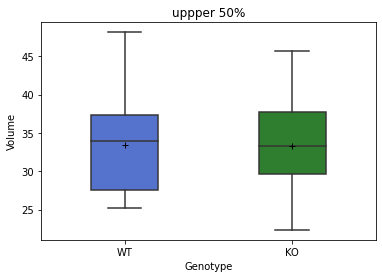

In [131]:
sns.boxplot(data = up_50, x = 'Genotype', y = 'Volume', palette=['royalblue', 'forestgreen'], order = ['WT', 'KO'], showmeans=True, showfliers = False, meanprops={'marker':'+', 'markeredgecolor':'k'}, width=0.4)
plt.title('uppper 50%')
box_ax.set_ylabel(r'Volume $\mu m^3$')
box_ax.set_xlabel('')

In [132]:
pg.normality(data = up_50, dv = 'Volume', group = 'Genotype')

,W,pval,normal
WT,0.950066,0.271840,True
KO,0.974560,0.905949,True


In [133]:
pg.ttest(up_50['Volume'][up_50['Genotype']=='WT'], up_50['Volume'][up_50['Genotype']=='KO'], tail = 'greater')

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,0.04174,29.709133,greater,0.483493,"[-3.46, inf]",0.013787,0.628,0.05448


In [134]:
WT_50down = mfb_df[['Volume', 'Genotype']][(mfb_df['Genotype']== 'WT') & (mfb_df['Volume']<24)]
KO_50down = mfb_df[['Volume', 'Genotype']][(mfb_df['Genotype']== 'KO') & (mfb_df['Volume']<20)]
down_50 = pd.concat([WT_50down, KO_50down])

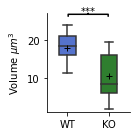

In [161]:
lower_50 = plt.figure(figsize = (2,2))
sns.boxplot(data = down_50, x = 'Genotype', y = 'Volume', palette=['royalblue', 'forestgreen'], order = ['WT', 'KO'], showmeans=True, showfliers = False, meanprops={'marker':'+', 'markeredgecolor':'k'}, width=0.4)
sns.despine()
plt.ylabel(r'Volume $\mu m^3$')
plt.ylim([1, 27])
plt.xlabel('')
plt.annotate('***', xy = (0.5, 0.99), xytext = (0.5, 0.99), xycoords = 'axes fraction', ha = 'center', arrowprops=dict(arrowstyle='-[, widthB=2, lengthB=.2', lw=1.5, color='k'), fontsize = 10)
plt.tight_layout()


In [162]:
lower_50.savefig('/Users/labc02/Documents/PDCB_data/Morphometry/Figures/MFBlower50.svg')

In [141]:
pg.normality(data = down_50, dv = 'Volume', group = 'Genotype')

,W,pval,normal
WT,0.922846,0.059503,True
KO,0.880167,0.021615,False


In [142]:
# Mann-Whitney U
pg.mwu(down_50['Volume'][down_50['Genotype']=='WT'], down_50['Volume'][down_50['Genotype']=='KO'], tail = 'greater')

,U-val,tail,p-val,RBC,CLES
MWU,398.0,greater,0.000075,-0.675789,0.837895


# Microglia Density

In [163]:
mgl_count = pd.read_csv('/Users/labc02/Documents/PDCB_data/Morphometry/microglia_density.csv')

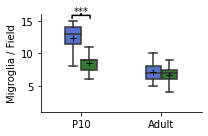

In [295]:
mgl_density = plt.figure(figsize=(3,2))
ax_ = sns.boxplot(data= mgl_count, x = 'Age', y = 'No_Microglia', hue = 'Genotype', palette=['royalblue', 'forestgreen'], showmeans=True, showfliers = False, meanprops={'marker':'+', 'markeredgecolor':'k'}, width = 0.4)
sns.despine()
plt.ylabel('Migroglia / Field')
plt.xlabel('')
ax_.set_xticklabels(['P10', 'Adult'])
plt.ylim(1, 16)
plt.annotate('***', xy = (0.25, 0.99), xytext = (0.25, 1), xycoords = 'axes fraction', ha = 'center', arrowprops=dict(arrowstyle='-[, widthB=.9, lengthB=.3', lw=1.5, color='k'), fontsize = 10)
ax_.get_legend().remove()
plt.tight_layout()


In [296]:
mgl_density.savefig('/Users/labc02/Documents/PDCB_data/Morphometry/Figures/mgl_density.svg')

In [188]:
pg.normality(data = mgl_count[mgl_count['Age']=='adult'], dv = 'No_Microglia', group = 'Genotype')

,W,pval,normal
WT,0.918969,0.037288,False
KO,0.946760,0.178717,True


In [189]:
pg.normality(data = mgl_count[mgl_count['Age']=='neo'], dv = 'No_Microglia', group = 'Genotype')

,W,pval,normal
WT,0.904247,0.016753,False
KO,0.950479,0.220206,True


In [195]:
pg.mwu(mgl_count['No_Microglia'][(mgl_count['Age']=='neo') & (mgl_count['Genotype']=='WT')], mgl_count['No_Microglia'][(mgl_count['Age']=='neo') & (mgl_count['Genotype']=='KO')])



,U-val,tail,p-val,RBC,CLES
MWU,670.0,two-sided,1.074890e-07,-0.838134,0.897119


In [196]:
pg.mwu(mgl_count['No_Microglia'][(mgl_count['Age']=='adult') & (mgl_count['Genotype']=='WT')], mgl_count['No_Microglia'][(mgl_count['Age']=='adult') & (mgl_count['Genotype']=='KO')])



,U-val,tail,p-val,RBC,CLES
MWU,418.5,two-sided,0.346358,-0.148148,0.491084


## Morphology

In [209]:
morph_df = pd.read_csv('/Users/labc02/Documents/PDCB_data/Morphometry/microglia_morph.csv')

In [210]:
morph_df.columns

Index(['Date', 'Genotype', 'Age', 'Subject', 'Section', 'Field', 'Cell',
       'Branches', 'End_points', 'Avg_Branch_lgth', 'Cable_length', 'Frac_dim',
       'Lacunarity', 'Density', 'Span', 'Circulariry'],
      dtype='object')

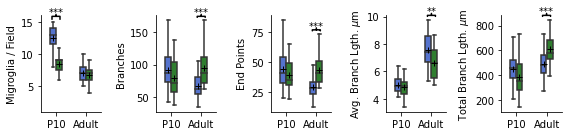

In [316]:
morph_fig = plt.figure(figsize=(8, 2))

ax_ = plt.subplot(151)
ax_ = sns.boxplot(data= mgl_count, x = 'Age', y = 'No_Microglia', hue = 'Genotype', palette=['royalblue', 'forestgreen'], showmeans=True, showfliers = False, meanprops={'marker':'+', 'markeredgecolor':'k'}, width = 0.4)
sns.despine()
plt.ylabel('Migroglia / Field')
plt.xlabel('')
ax_.set_xticklabels(['P10', 'Adult'])
plt.ylim(1, 16)
plt.annotate('***', xy = (0.25, 0.99), xytext = (0.25, 1), xycoords = 'axes fraction', ha = 'center', arrowprops=dict(arrowstyle='-[, widthB=.4, lengthB=.3', lw=1.5, color='k'), fontsize = 10)
ax_.get_legend().remove()
plt.tight_layout()

ax1 = plt.subplot(152)
sns.boxplot(data= morph_df, x = 'Age', y = 'Branches', hue = 'Genotype', order = ['Neo', 'Adult'], palette=['royalblue', 'forestgreen'], showmeans=True, showfliers = False, meanprops={'marker':'+', 'markeredgecolor':'k'}, width = 0.4)
sns.despine()
plt.ylabel('Branches')
ax1.set_xticklabels(['P10', 'Adult'])
plt.xlabel('')
ax1.annotate('***', xy = (0.75, 0.99), xytext = (0.75, 1), xycoords = 'axes fraction', ha = 'center', arrowprops=dict(arrowstyle='-[, widthB=0.4, lengthB=.1', lw=1.5, color='k'), fontsize = 10)
ax1.get_legend().remove()

ax2 = plt.subplot(153)
sns.boxplot(data= morph_df, x = 'Age', y = 'End_points', hue = 'Genotype', order = ['Neo', 'Adult'], palette=['royalblue', 'forestgreen'], showmeans=True, showfliers = False, meanprops={'marker':'+', 'markeredgecolor':'k'}, width = 0.4)
sns.despine()
plt.ylabel('End Points')
ax2.set_xticklabels(['P10', 'Adult'])
plt.xlabel('')
ax2.annotate('***', xy = (0.75, 0.85), xytext = (0.75, 0.86), xycoords = 'axes fraction', ha = 'center', arrowprops=dict(arrowstyle='-[, widthB=0.4, lengthB=.1', lw=1.5, color='k'), fontsize = 10)
ax2.get_legend().remove()

ax3 = plt.subplot(154)
sns.boxplot(data= morph_df, x = 'Age', y = 'Avg_Branch_lgth', hue = 'Genotype', order = ['Neo', 'Adult'], palette=['royalblue', 'forestgreen'], showmeans=True, showfliers = False, meanprops={'marker':'+', 'markeredgecolor':'k'}, width = 0.4)
sns.despine()
plt.ylabel(r'Avg. Branch Lgth. $\mu$m')
ax3.set_xticklabels(['P10', 'Adult'])
plt.xlabel('')
ax3.annotate('**', xy = (0.75, 1), xytext = (0.75, 1.01), xycoords = 'axes fraction', ha = 'center', arrowprops=dict(arrowstyle='-[, widthB=0.4, lengthB=.1', lw=1.5, color='k'), fontsize = 10)
ax3.get_legend().remove()

ax4 = plt.subplot(155)
sns.boxplot(data= morph_df, x = 'Age', y = 'Cable_length', hue = 'Genotype', order = ['Neo', 'Adult'], palette=['royalblue', 'forestgreen'], showmeans=True, showfliers = False, meanprops={'marker':'+', 'markeredgecolor':'k'}, width = 0.4)
sns.despine()
plt.ylabel(r'Total Branch Lgth. $\mu$m')
ax4.set_xticklabels(['P10', 'Adult'])
plt.xlabel('')
ax4.get_legend().remove()
ax4.annotate('***', xy = (0.75, 1), xytext = (0.75, 1.01), xycoords = 'axes fraction', ha = 'center', arrowprops=dict(arrowstyle='-[, widthB=0.4, lengthB=.1', lw=1.5, color='k'), fontsize = 10)

plt.tight_layout()

In [317]:
morph_fig.savefig('/Users/labc02/Documents/PDCB_data/Morphometry/Figures/morph_fig.svg')

#### Branches Stats

In [227]:
pg.normality(data = morph_df[morph_df['Age']=='Adult'], dv = 'Branches', group = 'Genotype')

,W,pval,normal
WT,0.970963,0.565858,True
KO,0.910232,0.013105,False


In [228]:
pg.normality(data = morph_df[morph_df['Age']=='Neo'], dv = 'Branches', group = 'Genotype')

,W,pval,normal
WT,0.955264,0.233349,True
KO,0.937602,0.070846,True


In [229]:
pg.mwu(morph_df['Branches'][(morph_df['Age']=='Neo') & (morph_df['Genotype']=='WT')], morph_df['Branches'][(morph_df['Age']=='Neo') & (morph_df['Genotype']=='KO')])


,U-val,tail,p-val,RBC,CLES
MWU,570.5,two-sided,0.129728,-0.226882,0.607527


In [230]:
pg.mwu(morph_df['Branches'][(morph_df['Age']=='Adult') & (morph_df['Genotype']=='WT')], morph_df['Branches'][(morph_df['Age']=='Adult') & (morph_df['Genotype']=='KO')])


,U-val,tail,p-val,RBC,CLES
MWU,178.0,two-sided,0.000036,0.617204,0.804301


### End Points

In [236]:
pg.normality(data = morph_df[morph_df['Age']=='Adult'], dv = 'End_points', group = 'Genotype')

,W,pval,normal
WT,0.963047,0.369690,True
KO,0.924553,0.031232,False


In [237]:
pg.normality(data = morph_df[morph_df['Age']=='Neo'], dv = 'End_points', group = 'Genotype')

,W,pval,normal
WT,0.964459,0.400471,True
KO,0.939744,0.081181,True


In [238]:
pg.mwu(morph_df['End_points'][(morph_df['Age']=='Neo') & (morph_df['Genotype']=='WT')], morph_df['End_points'][(morph_df['Age']=='Neo') & (morph_df['Genotype']=='KO')])


,U-val,tail,p-val,RBC,CLES
MWU,543.5,two-sided,0.260188,-0.168817,0.572043


In [239]:
pg.mwu(morph_df['End_points'][(morph_df['Age']=='Adult') & (morph_df['Genotype']=='WT')], morph_df['End_points'][(morph_df['Age']=='Adult') & (morph_df['Genotype']=='KO')])


,U-val,tail,p-val,RBC,CLES
MWU,145.0,two-sided,0.000004,0.688172,0.833333


### Avg. Branch Lgth.

In [249]:
pg.normality(data = morph_df[morph_df['Age']=='Adult'], dv = 'Avg_Branch_lgth', group = 'Genotype')

,W,pval,normal
WT,0.970305,0.547555,True
KO,0.939888,0.081930,True


In [250]:
pg.normality(data = morph_df[morph_df['Age']=='Neo'], dv = 'Avg_Branch_lgth', group = 'Genotype')

,W,pval,normal
WT,0.953143,0.205068,True
KO,0.979488,0.798286,True


In [251]:
pg.ttest(morph_df['Avg_Branch_lgth'][(morph_df['Age']=='Neo') & (morph_df['Genotype']=='WT')], morph_df['Avg_Branch_lgth'][(morph_df['Age']=='Neo') & (morph_df['Genotype']=='KO')])


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,0.935704,56.582164,two-sided,0.353402,"[-0.19, 0.53]",0.238688,0.377,0.150461


In [252]:
pg.ttest(morph_df['Avg_Branch_lgth'][(morph_df['Age']=='Adult') & (morph_df['Genotype']=='WT')], morph_df['Avg_Branch_lgth'][(morph_df['Age']=='Adult') & (morph_df['Genotype']=='KO')])


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,3.184676,58.658021,two-sided,0.002321,"[0.34, 1.51]",0.816207,15.366,0.879945


### Cable Lenght

In [256]:
pg.normality(data = morph_df[morph_df['Age']=='Adult'], dv = 'Cable_length', group = 'Genotype')

,W,pval,normal
WT,0.986170,0.955385,True
KO,0.944424,0.109416,True


In [257]:
pg.normality(data = morph_df[morph_df['Age']=='Neo'], dv = 'Cable_length', group = 'Genotype')

,W,pval,normal
WT,0.963537,0.380163,True
KO,0.957570,0.251283,True


In [258]:
pg.ttest(morph_df['Cable_length'][(morph_df['Age']=='Neo') & (morph_df['Genotype']=='WT')], morph_df['Cable_length'][(morph_df['Age']=='Neo') & (morph_df['Genotype']=='KO')])


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,1.814147,58.573082,two-sided,0.074778,"[-6.53, 133.06]",0.463701,1.024,0.429107


In [259]:
pg.ttest(morph_df['Cable_length'][(morph_df['Age']=='Adult') & (morph_df['Genotype']=='WT')], morph_df['Cable_length'][(morph_df['Age']=='Adult') & (morph_df['Genotype']=='KO')])


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-3.81375,58.208012,two-sided,0.000333,"[-181.03, -56.41]",0.974299,79.231,0.962598


Text(0.5, 0, '')

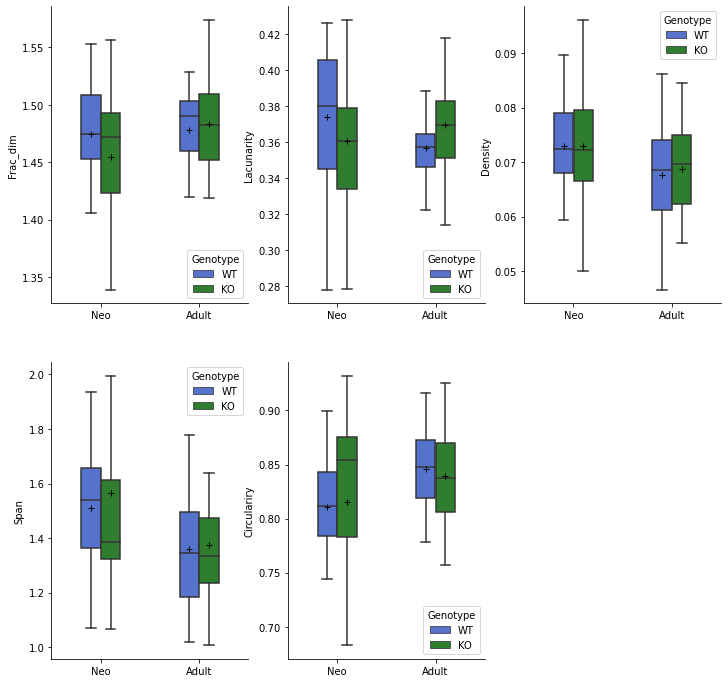

In [216]:
morph_fig2 = plt.figure(figsize=(12, 12))

ax1 = plt.subplot(231)
sns.boxplot(data= morph_df, x = 'Age', y = 'Frac_dim', hue = 'Genotype', order = ['Neo', 'Adult'], palette=['royalblue', 'forestgreen'], showmeans=True, showfliers = False, meanprops={'marker':'+', 'markeredgecolor':'k'}, width = 0.4)
sns.despine()
plt.ylabel('Frac_dim')
plt.xlabel('')

ax2 = plt.subplot(232)
sns.boxplot(data= morph_df, x = 'Age', y = 'Lacunarity', hue = 'Genotype', order = ['Neo', 'Adult'], palette=['royalblue', 'forestgreen'], showmeans=True, showfliers = False, meanprops={'marker':'+', 'markeredgecolor':'k'}, width = 0.4)
sns.despine()
plt.ylabel('Lacunarity')
plt.xlabel('')

ax3 = plt.subplot(233)
sns.boxplot(data= morph_df, x = 'Age', y = 'Density', hue = 'Genotype', order = ['Neo', 'Adult'], palette=['royalblue', 'forestgreen'], showmeans=True, showfliers = False, meanprops={'marker':'+', 'markeredgecolor':'k'}, width = 0.4)
sns.despine()
plt.ylabel('Density')
plt.xlabel('')

ax4 = plt.subplot(234)
sns.boxplot(data= morph_df, x = 'Age', y = 'Span', hue = 'Genotype', order = ['Neo', 'Adult'], palette=['royalblue', 'forestgreen'], showmeans=True, showfliers = False, meanprops={'marker':'+', 'markeredgecolor':'k'}, width = 0.4)
sns.despine()
plt.ylabel('Span')
plt.xlabel('')

ax5 = plt.subplot(235)
sns.boxplot(data= morph_df, x = 'Age', y = 'Circulariry', hue = 'Genotype', order = ['Neo', 'Adult'], palette=['royalblue', 'forestgreen'], showmeans=True, showfliers = False, meanprops={'marker':'+', 'markeredgecolor':'k'}, width = 0.4)
sns.despine()
plt.ylabel('Circulariry')
plt.xlabel('')